# To-do
* Może jakieś komentarze dodać


In [1]:
!nvidia-smi

Thu Jan 18 21:25:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from sklearn.preprocessing import LabelEncoder
import os
import torch.nn.init as init
import numpy as np
import cv2
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import time
from torch.optim.lr_scheduler import StepLR

In [3]:
# Konfiguracja urządzenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive #Zakomentować albo usunnąć jeżeli nie używacie google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/NN/Project III

/content/drive/MyDrive/Colab Notebooks/NN/Project III


In [6]:
%ldir

drwx------ 2 root      4096 Jan 10 19:09 CatBreedsRefined-v2/


# Podział zbioru danych

In [7]:
def make_dataframes(train_dir, test_dir = None , val_dir = None, min_images = None):
    bad_images=[]
    skip_classes=[]

    # Sprawdzenie jakie katalogi istnieją
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir, val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir, test_dir]
        names=['train', 'test']
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test','valid']

    ht=0
    wt=0
    total_good_files=0 #

    for name, dir in zip(names, dirlist):
        filepaths=[] # Lista ścieżek poszczególnych obrazków
        labels=[] # Lista labelków do poszczególnych obrazków
        classlist=sorted(os.listdir(dir)) # Lista wszystkich klas w zbiorze danych w kolejności alfabetycznej

        for cl in classlist:
            msg=f'Processing images in {name} directory for class {cl}                                                  '
            print(msg, '\r', end='')
            good_file_count=0
            classpath=os.path.join(dir, cl) # Pełna ścieżka do plików danej klasy

            if os.path.isdir(classpath):
                flist=sorted(os.listdir(classpath)) # Lista plików dla danej klasy

                if name == 'train' and len(flist) < min_images:
                    skip_classes.append(cl)
                else:
                    if cl not in skip_classes:
                        for f in flist:
                            fpath=os.path.join(classpath,f) # Stwórz pełną ścieżkę do obrazka
                            index=f.rfind('.')
                            ext=f[index+1:].lower() # Rozszerzenie pliku
                            if ext not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp'] :   # Sprawdzenie poprawności rozszerzenia pliku
                                bad_images.append(fpath) # Dodaj ścieżkę do listy złych obrazków, jeżeli ma złe rozszerzenie
                            else:
                                try: # Sprawdzenie, czy obrazki są defektywne
                                    img=cv2.imread(fpath)
                                    h=img.shape[0]
                                    w=img.shape[1]
                                    # Dodawanie wartości liczników
                                    ht += h
                                    wt += w
                                    good_file_count += 1
                                    total_good_files += 1
                                    filepaths.append(fpath) # Dodawanie do listy poprawnych obrazków
                                    labels.append(cl) # Dodanie labelki do listy poprawnych labelków
                                except:
                                    bad_images.append(fpath) # Dodawanie do listy złych obrazków

        # Pandas series zawierające odpowiednio ścieżki obrazków i ich labelki
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) # Łączenie labelków i obrazków w jedną ramkę danych

        # Tworzenie odpowiedniego df w zależności czy istnieją odzielne katologi danych treningowych, testowych i walidacyjnych
        if name =='valid':
            valid_df = df
        elif name == 'test':
            test_df = df
        else:
            if test_dir == None and val_dir == None:
                train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
                valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None:
                train_df,test_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
            elif val_dir == None:
                train_df,valid_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
            else:
                train_df = df

    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)

    # Średnia wysokość i szerokość obrazka
    h_ave= int(ht/total_good_files)
    w_ave= int(wt/total_good_files)


    print('Avarage size of the photo is: ', h_ave, ' x ', w_ave, '.')

    print('Number of classes in processed dataset = ', class_count)

    if len(skip_classes)>0:
        msg=f'Listed below are classes not included in the dataset because it had less than {min_images} training image files'

        for cl in skip_classes:
            print(cl)

    counts=list(train_df['labels'].value_counts())

    print('The maximum files in any class in train_df is ', max(counts), '. The minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

    if len(bad_images) == 0:
        print('All image files were properly processed and used in the dataframes')
    else:
        print(f'There are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)

    return train_df, test_df, valid_df, classes, class_count

In [8]:
train_df, test_df, valid_df, classes, class_count = make_dataframes(train_dir = 'CatBreedsRefined-v2/', min_images = 100)

Avarage size of the photo is:  469  x  471 .
Number of classes in processed dataset =  20
The maximum files in any class in train_df is  280 . The minimum files in any class in train_df is  280
train_df length:  5600   test_df length:  700   valid_df length:  700
All image files were properly processed and used in the dataframes


In [9]:
train_df

,filepaths,labels
5386,CatBreedsRefined-v2/Russian Blue/Russian Blue_...,Russian Blue
1007,CatBreedsRefined-v2/American Curl/American Cur...,American Curl
4341,CatBreedsRefined-v2/Norwegian Forest/Norwegian...,Norwegian Forest
1992,CatBreedsRefined-v2/Birman/Birman_317.jpg,Birman
4286,CatBreedsRefined-v2/Norwegian Forest/Norwegian...,Norwegian Forest
...,...,...
218,CatBreedsRefined-v2/Abyssinian/Abyssinian_296.jpg,Abyssinian
4035,CatBreedsRefined-v2/Manx/Manx_266.jpg,Manx
1464,CatBreedsRefined-v2/Bengal/Bengal_157.jpg,Bengal
2401,CatBreedsRefined-v2/Bombay/Bombay_55.jpg,Bombay


In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [11]:
# Klasa, która tworzy dataset potrzebny do data loadera z naszego zbioru danych
class CatBreedDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.cat_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cat_frame)

    def __getitem__(self, idx):
        img_name = self.cat_frame.iloc[idx, 0]
        image = Image.open(img_name)
        breed_name = self.cat_frame.iloc[idx, 1]
        label = label_encoder.transform([breed_name])[0]


        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
batch_size = 64

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10), # Zastosowanie augumentacji danych
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Parametry zaczerpnięte z papieru naukowego dot. architektury
])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Parametry zaczerpnięte z papieru naukowego dot. architektury
])

cat_dataset_train = CatBreedDataset(dataframe=train_df, root_dir='CatBreedsRefined-v2/', transform=transform_train)
train_loader = DataLoader(cat_dataset_train, batch_size=batch_size, shuffle=True)

cat_dataset_test = CatBreedDataset(dataframe=test_df, root_dir='CatBreedsRefined-v2/', transform=transform)
test_loader = DataLoader(cat_dataset_test, batch_size=batch_size, shuffle=False)

cat_dataset_valid = CatBreedDataset(dataframe=valid_df, root_dir='CatBreedsRefined-v2/', transform=transform)
valid_loader = DataLoader(cat_dataset_valid, batch_size=batch_size, shuffle=False)

# Wizualizacja zbioru danych

In [13]:
def imshow(img):
  """
  Funkcja służaca do przedstawiania obrazków z batcha.
  """
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

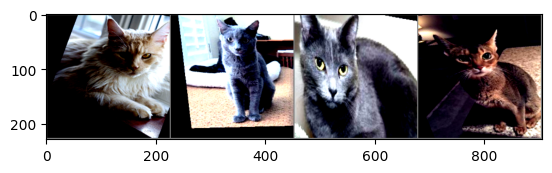

In [14]:
# Weźmy kilka losowych obrazków z danych treningowych
dataiter = iter(train_loader)
images, labels = next(dataiter)

#  Stworzenie siatki obrazków z próbki z pojedyńczego batcha
imshow(torchvision.utils.make_grid(images[:4]))

# Implementacja klasy EarlyStopping

In [15]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_loss = float('inf')

    def __call__(self, loss):
        if (self.best_loss - loss) < self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

        return self.early_stop

# Zbudowanie modelu

## Model VGG16

Poniższa architektura prezentuje implementację modelu popularnej architerktury do klasyfikacji obrazków - VGG16.

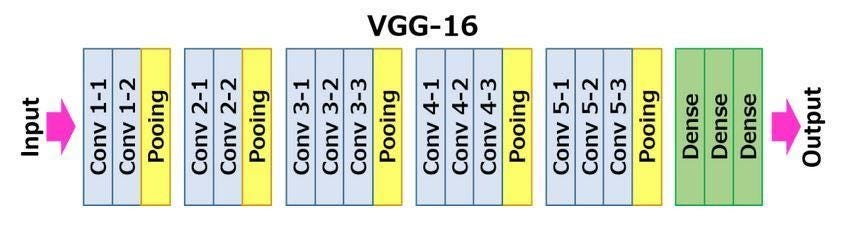

In [16]:
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGGNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 20):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)),
                            nn.BatchNorm2d(x),
                            nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)

In [17]:
# Hiperparametry
learning_rate = 0.001

In [18]:
# Inicjalizacja modelu, funkcji straty oraz optimizera
model = VGGNet().to(device)
model.load_state_dict(torch.load('best_model.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Metryki ewualuacji modelu

W komenatrzach do poniższej klasy compute_metrics używamy poniższych skrótów:

* "TP" to liczba przypadków, w których model poprawnie zidentyfikował pozytywne przypadki.
* "FP" to liczba przypadków, w których model błędnie zidentyfikował pozytywne przypadki, chociaż w rzeczywistości były ona negatywne. Innymi słowy, model myli się, przewidując pozytywną klasę, gdy nie powinien.
* "FN" to liczba przypadków, w których model błędnie przewidział negatywną klasę, chociaż w rzeczywistości była ona pozytywna.Czyli model pominął wykrycie rzeczywistego pozytywnego przypadku.
* "TN" to liczba przypadków,  w których model poprawnie przewidział negatywną klasę. Możemy powiedzieć, że model poprawnie stwierdził, że dany przypadek nie należy do pozytywnej klasy.

In [29]:
class compute_metrics():
    def __init__(self):
        pass

    @staticmethod
    # poprawne predykcje/liczba prób
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    def accuracy(model, data_loader):
        model.eval()
        n_correct = 0
        n_samples = 0
        with torch.no_grad():
            for X, y in data_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                _, prediction = pred.max(1)
                n_correct += (prediction == y).sum().item()
                n_samples += prediction.size(0)
        accuracy = n_correct / n_samples * 100
        return accuracy

    @staticmethod
    #suma strat dla wszystkich prób / liczba wszystkich prób
    def average_loss(model, data_loader):
        model.eval()
        total_loss = 0.0
        n_samples = 0
        with torch.no_grad():
            for X, y in data_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                loss = criterion(pred, y)
                total_loss += loss.item() * X.size(0)
                n_samples += X.size(0)
        average_loss = total_loss / n_samples
        return average_loss


    @staticmethod
    def precision(model, data_loader, num_classes = 20):
        model.eval()
        correct_positives = [0] * num_classes
        all_positives = [0] * num_classes

        with torch.no_grad():
            for X, y in data_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                _, predictions = pred.max(1)

                for class_idx in range(num_classes):
                    correct_positives[class_idx] += ((predictions == class_idx) & (y == class_idx)).sum().item()
                    all_positives[class_idx] += (predictions == class_idx).sum().item()

        precision = [correct_positives[i] / all_positives[i] if all_positives[i] > 0 else 0 for i in range(num_classes)]
        precision_percent = [p * 100 for p in precision]  #Zmiana na %
        return precision_percent

    @staticmethod
    def recall(model, data_loader, num_classes = 20):
        model.eval()
        correct_positives = [0] * num_classes
        all_actual_positives = [0] * num_classes

        with torch.no_grad():
            for X, y in data_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                _, predictions = pred.max(1)

                for class_idx in range(num_classes):
                    correct_positives[class_idx] += ((predictions == class_idx) & (y == class_idx)).sum().item()
                    all_actual_positives[class_idx] += (y == class_idx).sum().item()

        recall = [correct_positives[i] / all_actual_positives[i] if all_actual_positives[i] > 0 else 0 for i in range(num_classes)]
        recall_percent = [r * 100 for r in recall]  #Zmiana na %
        return recall_percent

    @staticmethod
    #F1-score=2× [(Precision+Recall)/(Precision×Recall)]
    def F1_score(recall, precision, epsilon=1e-7): #epsilon jest małą wartością która jest dodawana, by nie wystąpiło dzielenie przez 0
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        return f1

# Trening modelu

In [20]:
def train_one_epoch(model, dataloader):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Policzenie dokładności
        _, predicted = torch.max(pred.data, 1)
        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples * 100
    return average_loss, accuracy

In [21]:
def validate_one_epoch(model, dataloader):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = criterion(pred, y)

            total_loss += loss.item()

            # Policzenie dokładności
            _, predicted = torch.max(pred.data, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples * 100
    return average_loss, accuracy

In [22]:
def train_with_early_stopping(model, train_loader, valid_loader, early_stopping, scheduler, filename, num_epochs=100):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    early_stopping_epoch = None
    best_valid_accuracy = 0.0
    best_epoch = 0

    # Inicjalizacja pliku do zapisywania wyników treningu
    with open(filename, 'a') as file:
        file.write("Epoch, Train Loss, Train Accuracy, Valid Loss, Valid Accuracy\n")

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}")

            # Trening
            train_loss, train_accuracy = train_one_epoch(model, train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            print(f"Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%")

            # Walidacja
            valid_loss, valid_accuracy = validate_one_epoch(model, valid_loader)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)
            print(f"Valid Loss: {valid_loss:.6f}, Valid Accuracy: {valid_accuracy:.2f}%")

            # Zapisywanie wyników z epoki do pliku
            file.write(f"{epoch + 1}, {train_loss:.6f}, {train_accuracy:.2f}%, {valid_loss:.6f}, {valid_accuracy:.2f}%\n")

            # Sprawdzenie najlepszej dokładności danych walidacyjnych i zapisywanie modelu
            if valid_accuracy > best_valid_accuracy:
                best_valid_accuracy = valid_accuracy
                best_epoch = epoch
                torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
                print(f"New best model saved with {valid_accuracy:.2f}% accuracy at epoch {epoch + 1}")

            # Sprawdzanie early stoppingu
            early_stopping(valid_loss)
            if early_stopping.early_stop:
                early_stopping_epoch = epoch
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # krok schedulera lr
            scheduler.step()

    return train_losses, valid_losses, train_accuracies, valid_accuracies, early_stopping_epoch, best_valid_accuracy, best_epoch

In [ ]:
num = 2

# Inicjalizacja wczesnego zatrzymywania
early_stopping = EarlyStopping(tolerance=10, min_delta=0.01)

# Rozpocznij trening z wczesnym zatrzymywaniem, accuracy i zapisem wartości straty w każdej epoce
train_losses, valid_losses, train_accuracies, valid_accuracies, early_stopping_epoch, best_valid_acc, best_epoc = train_with_early_stopping(model,
                                                                                                                                            train_loader,
                                                                                                                                            valid_loader,
                                                                                                                                            early_stopping,
                                                                                                                                            scheduler,
                                                                                                                                            f'training_results_{num}.dat')

Epoch 1
Train Loss: 0.399790, Train Accuracy: 86.20%
Valid Loss: 1.559491, Valid Accuracy: 61.29%
New best model saved with 61.29% accuracy at epoch 1
Epoch 2
Train Loss: 0.411854, Train Accuracy: 85.75%
Valid Loss: 1.761686, Valid Accuracy: 59.86%
Epoch 3
Train Loss: 0.418325, Train Accuracy: 85.38%
Valid Loss: 1.599945, Valid Accuracy: 62.86%
New best model saved with 62.86% accuracy at epoch 3
Epoch 4
Train Loss: 0.399407, Train Accuracy: 85.96%
Valid Loss: 2.062503, Valid Accuracy: 59.00%
Epoch 5
Train Loss: 0.368920, Train Accuracy: 87.07%
Valid Loss: 1.795445, Valid Accuracy: 58.43%
Epoch 6
Train Loss: 0.294711, Train Accuracy: 90.04%
Valid Loss: 1.418117, Valid Accuracy: 66.14%
New best model saved with 66.14% accuracy at epoch 6
Epoch 7
Train Loss: 0.251629, Train Accuracy: 91.96%
Valid Loss: 1.412843, Valid Accuracy: 66.43%
New best model saved with 66.43% accuracy at epoch 7
Epoch 8
Train Loss: 0.235888, Train Accuracy: 92.71%
Valid Loss: 1.436342, Valid Accuracy: 66.00%
Epoc

Powyższa informacja zwrotna stanowi jedynie część z treningu modelu. Zważywszy na długi czas treningu, odbywał się on w częsciach.

# Wyniki trenowania modelu

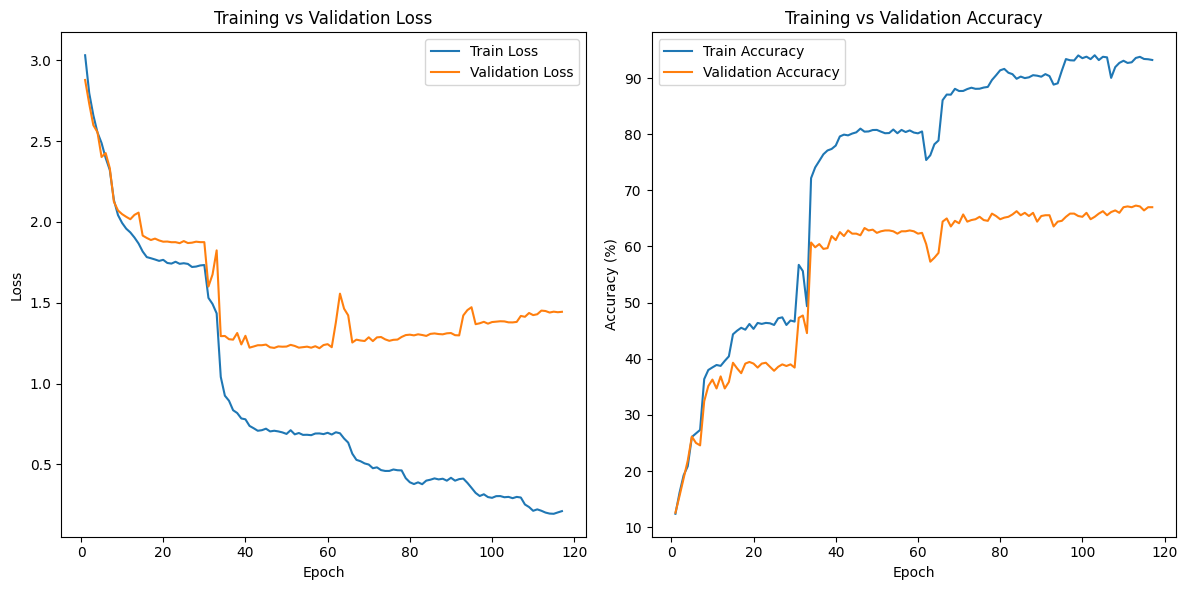

In [23]:
# Wczytanie pliku z wynikami
file_path = '/content/drive/MyDrive/Colab Notebooks/NN/Project III/training_results.dat'
df = pd.read_csv(file_path)

# Przekonwertowanie stringa z procentami na float
df['Train Accuracy'] = df['Train Accuracy'].str.rstrip('%').astype('float')
df['Valid Accuracy'] = df['Valid Accuracy'].str.rstrip('%').astype('float')

plt.figure(figsize=(12, 6))

# Wykres funkcji straty
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Valid Loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Valid Accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Na podstawie powyższych wykresów możemy wyciągnąć następujące wnioski dotyczące treningu modelu:

* **Spadek funkcji straty:** Zauważalny jest ogólny trend spadkowy zarówno w funkcji straty treningowej, jak i walidacyjnej, co wskazuje na to, że model z każdą epoką coraz lepiej dopasowuje się do danych.

* **Dynamika nauki:** Wartości straty dla danych walidacyjnych wykazują pewne fluktuacje, co może wskazywać na to, że w tych punktach model mógł napotkać trudniejsze do nauki przypadki lub że wystąpiły wahania w procesie uczenia się.

* **Dokładność modelu:** Dokładność (accuracy) dla danych treningowych i walidacyjnych generalnie wzrasta, co świadczy o poprawnym uczeniu się modelu. Mimo to, na wykresie dokładności dla danych walidacyjnych widoczne są pewne spadki, co może wskazywać na przeuczenie (overfitting) modelu - model może zbyt mocno dopasowywać się do danych treningowych kosztem zdolności do generalizacji.
Związane może to być ze stosunkowo niewielkim (5600 obrazków) zbiorem danych uczących.


# Ewaluacja modelu

In [32]:
def predict(model, image, classes):
    model.eval()

    # Sprawdź, czy obrazek jest w formie tensora, jeśli tak, użyj go bezpośrednio
    if isinstance(image, torch.Tensor):
        img_batch = image.unsqueeze(0).to(device)
    else:
        # Załadowanie obrazka i transformacja danych
        img = Image.open(image)
        img_transformed = transform(img)


        img_batch = img_transformed.unsqueeze(0).to(device)

    # Stworzenie predykcji
    with torch.no_grad():
        _, predicted_idx = model(img_batch).max(1)

    # Zmapowanie indeksu do nazwy rasy
    predicted_class = classes[predicted_idx.item()]

    return predicted_class

In [ ]:
#predict(model, '/content/test.jpg', classes)

In [25]:
print(f'Dokładność modelu dla danych testowych wynosi: {compute_metrics.accuracy(model, test_loader):.2f}%.')

Dokładność modelu dla danych testowych wynosi: 68.71%.


In [26]:
recall = compute_metrics.recall(model, test_loader)
precision =  compute_metrics.precision(model, test_loader)

In [30]:
f1_score = [compute_metrics.F1_score(r, p) for r, p in zip(recall, precision)]

In [31]:
pd.DataFrame({'Classes': classes, "Recall": recall, "Precision": precision, 'F1 score': f1_score})

,Classes,Recall,Precision,F1 score
0,Abyssinian,80.000000,70.000000,74.666667
1,American Bobtail,22.857143,23.529412,23.188406
2,American Curl,62.857143,66.666667,64.705882
3,American Shorthair,51.428571,54.545455,52.941176
4,Bengal,74.285714,66.666667,70.270270
5,Birman,65.714286,69.696970,67.647059
6,Bombay,80.000000,71.794872,75.675676
7,British Shorthair,62.857143,66.666667,64.705882
8,Egyptian Mau,80.000000,70.000000,74.666667
9,Exotic Shorthair,80.000000,87.500000,83.582090


Analiza wyników treningu modelu na danych testowych dla rozpoznawania różnych ras kotów pokazuje, że model ma różne poziomy skuteczności w zależności od klasy. Na podstawie powyższych wartości powyższych metryk (recall oraz precyzja), możemy wyciągnąć kilka ciekawych wniosków dla poszczególnych ras:

1. **Abyssinian:** Wysoki Recall (80.00%) i dobra Precyzja (70.00%). Model dobrze rozpoznaje tę rasę, ale nieco częściej myli inne rasy z Abyssinian.

2. **American Bobtail:** Niska skuteczność zarówno w Recall (22.86%) jak i Precyzji (23.53%). Model ma trudności z rozpoznaniem tej rasy.

3. **Sphynx:** Bardzo wysoki Recall (91.43%) i wysoka Precyzja (84.21%). Model świetnie radzi sobie z rozpoznawaniem Sphynx.

4. **Maine Coon i Ragdoll:** Średni Recall, ale wysoka Precyzja. Model często pomija te rasy, ale gdy już je rozpozna, jest w tym dokładny.

5. **Scottish Fold:** Bardzo wysokie wartości dla obu wskaźników (Recall: 88.57%, Precyzja: 86.11%). Model doskonale radzi sobie z rozpoznawaniem tej rasy.

Generalnie, model wykazuje różny poziom skuteczności dla różnych ras kotów. Niektóre rasy są rozpoznawane z dużą dokładnością i czułością, podczas gdy inne sprawiają modelowi większą trudność. Może to być spowodowane różnymi czynnikami, takimi jak charakterystyczne cechy ras, różnorodność danych treningowych dla poszczególnych klas, czy też ogólna trudność w rozróżnieniu niektórych ras.

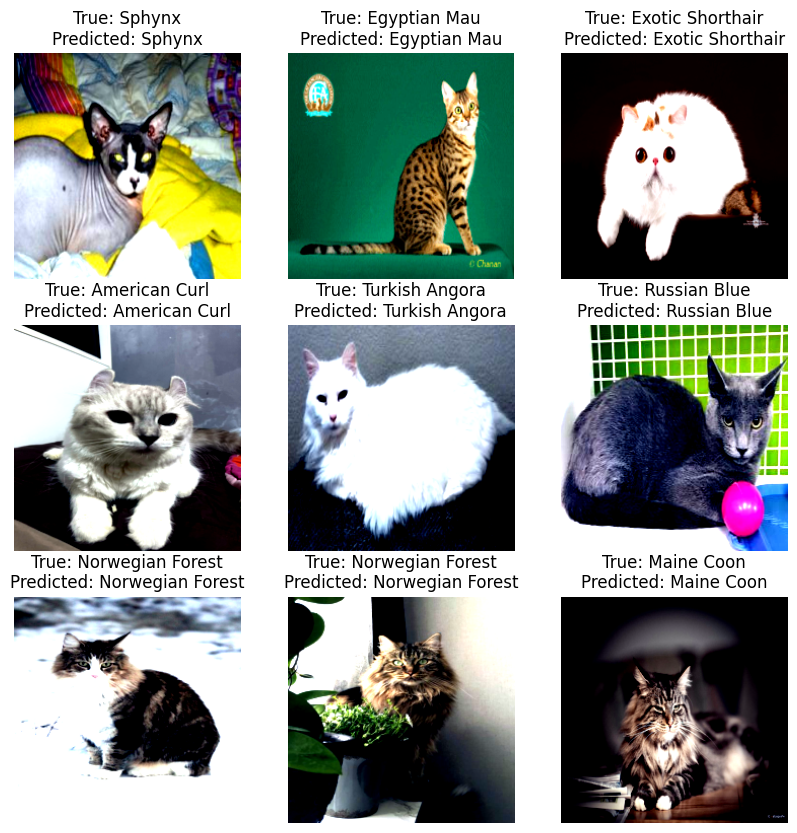

<Figure size 640x480 with 0 Axes>

In [42]:
def visualize_predictions(model, dataset, classes, transform, num_examples=9):
    model.eval()

    # Wybierz losowe przykłady z zestawu testowego
    examples = np.random.choice(len(dataset), num_examples, replace=False)

    # Przygotuj subplot
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, example_idx in enumerate(examples):
        # Pobierz obrazek i labelkę z zestawu testowego
        image, true_class = dataset[example_idx]

        # Wykonaj predykcję
        predicted_class = predict(model, image, classes)

        # Wyświetl oryginalny obrazek i klasy
        if isinstance(image, torch.Tensor):
            # Jeśli obrazek jest już tensorem, użyj go bezpośrednio
            image_display = np.transpose(torchvision.utils.make_grid(image / 2 + 0.5).cpu().numpy(), (1, 2, 0))
        else:
            # W przeciwnym razie załaduj obrazek i zastosuj transformację
            image_display = np.transpose(torchvision.utils.make_grid(transform(image / 2 + 0.5)).cpu().numpy(), (1, 2, 0))

        axes[i // 3, i % 3].imshow(image_display)
        axes[i // 3, i % 3].set_title(f'True: {classes[true_class]}\nPredicted: {predicted_class}')
        axes[i // 3, i % 3].axis('off')

    plt.show()


visualize_predictions(model, cat_dataset_test, classes, transform)